$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Data creation
<a id=part1></a>

we will start by setting up our datasets and dataloaders, then splitting data into train/validation/test sets

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import pickle


import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})

In [3]:
import torchtext
from torchtext import data
from torchtext import datasets

# create Field objects
ID = data.Field(sequential=False, dtype=torch.int8, use_vocab=True)
TARGET = data.Field(sequential=False, lower=True, dtype=torch.long, use_vocab=True)
TWEET = data.Field(sequential=True, use_vocab=True, lower=True,
    init_token='<sos>', eos_token='<eos>', dtype=torch.long)
STANCE = data.Field( is_target=True, sequential=False, unk_token=None, use_vocab=True)
SENTIMENT = data.Field( is_target=True, sequential=False, unk_token=None, use_vocab=True)

# create tuples representing the columns
fields = [
   ('ID', ID),
  ('TARGET', TARGET),
  ('TWEET', TWEET),
  ('STANCE', STANCE),
  (None, None), # ignore column
  ('SENTIMENT', SENTIMENT)
]


# load the dataset in json format
train_ds, valid_ds, test_ds = data.TabularDataset.splits(
   path = 'data-all-annotations',
   train = 'trainingdata-all-annotations.txt',
   validation = 'legalization_of_abortion_valid_set.txt',
   test = 'legalization_of_abortion_test_set.txt',
   format = 'tsv',
   fields = fields,
skip_header = True
)

# check an example
print(vars(train_ds[1]))
print(vars(valid_ds[100]))
print(len(train_ds))

C:\Users\User\anaconda3\envs\AI-project\lib\site-packages\torchtext\data\field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
C:\Users\User\anaconda3\envs\AI-project\lib\site-packages\torchtext\data\example.py:68: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)
C:\Users\User\anaconda3\envs\AI-project\lib\site-packages\torchtext\data\example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and mo

{'ID': '102', 'TARGET': 'atheism', 'TWEET': ['blessed', 'are', 'the', 'peacemakers,', 'for', 'they', 'shall', 'be', 'called', 'children', 'of', 'god.', 'matthew', '5:9', '#scripture', '#peace', '#semst'], 'STANCE': 'AGAINST', 'SENTIMENT': 'POSITIVE'}
{'ID': '2413', 'TARGET': 'legalization of abortion', 'TWEET': ['@showtruth', 'no,', 'i', "can't", 'explain', 'why', 'you', 'would', 'consider', 'a', 'medical', 'procedure', 'that', 'leaves', 'the', 'patient', 'healthy', '&', 'happy', 'as', 'killing.', '#semst'], 'STANCE': 'FAVOR', 'SENTIMENT': 'NEGATIVE'}
2814


### Data Pre-processing
<a id=part1_3></a>

The first thing we'll need to build a vocabulary for our fields 

In [4]:
ID.build_vocab(train_ds)
TARGET.build_vocab(train_ds)
TWEET.build_vocab(train_ds)
STANCE.build_vocab(train_ds)
SENTIMENT.build_vocab(train_ds)

print(f"Number of tokens in training samples: {len(TWEET.vocab)}")
print(f"Number of tokens in training stance labels: {len(STANCE.vocab)}")
print(f"Number of tokens in training sentiment labels: {len(SENTIMENT.vocab)}")

Number of tokens in training samples: 12528
Number of tokens in training stance labels: 3
Number of tokens in training sentiment labels: 3


In [5]:
print(f'first 20 tokens:\n', TWEET.vocab.itos[:20], end='\n\n')

first 20 tokens:
 ['<unk>', '<pad>', '<sos>', '<eos>', '#semst', 'the', 'to', 'a', 'of', 'is', 'and', 'you', 'i', 'in', 'for', 'be', 'that', 'are', 'on', 'not']



In [6]:
print(f'stance labels vocab:\n', dict(STANCE.vocab.stoi))
print(f'sentiment labels vocab:\n', dict(SENTIMENT.vocab.stoi))

stance labels vocab:
 {'AGAINST': 0, 'NONE': 1, 'FAVOR': 2}
sentiment labels vocab:
 {'NEGATIVE': 0, 'POSITIVE': 1, 'NEITHER': 2}


# Data Loaders

we want to be able to create batches and to iterate through the datasets for that we need to define data loaders 


In [7]:
BATCH_SIZE = 10

dl_train, dl_valid, dl_test = torchtext.data.BucketIterator.splits(
    (train_ds, valid_ds, test_ds), batch_size=BATCH_SIZE,
    shuffle=True, sort=False)

C:\Users\User\anaconda3\envs\AI-project\lib\site-packages\torchtext\data\iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


this is what a single batch looks like

In [8]:
batch = next(iter(dl_train))

X, y_stance, y_sentiment= batch.TWEET, batch.STANCE, batch.SENTIMENT
print('X = \n', X, X.shape, end='\n\n')
print('y = \n', y_stance, y_stance.shape)

X = 
 tensor([[    2,     2,     2,     2,     2,     2,     2,     2,     2,     2],
        [  929,  5429,  6599,  6091,  4220,  8091,    50,   823,  2319,  5427],
        [ 5551,    84,   657,    21,    50,   105,  6120,    47,    11,    19],
        [    9,    32,   294,    22, 11836,  1754,    73,    42,    70,   392],
        [  155,  6887, 11421,     7,   262,    14,    12,    19,     5,    12],
        [ 1770,     6,    96,  3425,  1814,  6960,    70,  3017,   613,   405],
        [    6,    89,   579,   298,    48,  9836,   439,    49,     6,    23],
        [   15,   862,     4,  1119,    60,     7,   593, 10272,   506,    63],
        [  404,    29,     3,   920,  8936, 11582,    53,    46,     7,   604],
        [    6, 10881,     1,     4,   417,  1213,     6,    77,  1153,  2507],
        [   22,    29,     1,     3,     5,    28,    15,   800, 11056,    20],
        [    7,    53,     1,     1,   416,   558,   404,  2700,   123,     9],
        [11816,  1643,     1,     

C:\Users\User\anaconda3\envs\AI-project\lib\site-packages\torchtext\data\batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


# Model Implementation

In our problem stands the difficulties of stance detection, where the sentiment is not generic but with respect to a specific topic. 
as stated in our proposed solution we will build a RNN based deep neural network within a two-phase architecture,
first we will experiment with a more sophisticated version of RNN which is the LSTM architecture. 

### the two-phase architecture

##### the first phase (subjectivity classification):
1. Layer of embedding
2. Layer of LSTM 
3. Linear classification layer  classify (positive \ negative \ neutral)

testing the model:

In [9]:
from implementations.models import SubjectivityLSTM

EMB_DIM = 128
HID_DIM = 64
NUM_LAYERS = 2
DROP_OUT = 0.1
VOCAB_SIZE = len(TWEET.vocab)

sub = SubjectivityLSTM(VOCAB_SIZE, EMB_DIM, HID_DIM,NUM_LAYERS,DROP_OUT)
out, h, ht = sub(X)
print(f'h (S, B, H): {h.shape}')
print(f'ht (L, B, H): {ht[0].shape}')
print(f'out (S, B, H): {out.shape}')

h (S, B, H): torch.Size([27, 10, 64])
ht (L, B, H): torch.Size([2, 10, 64])
out (S, B, H): torch.Size([27, 10, 3])



##### the second phase (stance detection):
1. Layer of self-attention
2. Layer of LSTM
3. Linear classification layer classify (favor \ against).

In [10]:
from implementations.models import StanceLSTM

stance = StanceLSTM(VOCAB_SIZE, EMB_DIM, HID_DIM,NUM_LAYERS,DROP_OUT)
yhat, _ = stance(X, ht, h)
print(f'yhat (S, B, V_tgt): {yhat.shape}')

yhat (S, B, V_tgt): torch.Size([27, 10, 3])


now for the model that includes both

In [11]:
from implementations.models import TwoPhaseLSTM

two_phase_model = TwoPhaseLSTM(VOCAB_SIZE, EMB_DIM, HID_DIM,NUM_LAYERS,DROP_OUT)
y_stance, y_sub = two_phase_model(X)
print('y_stance: (S, B, V_tgt) =', tuple(y_stance.shape))
print('y_sub: (S, B, V_tgt) =', tuple(y_sub.shape))

y_stance: (S, B, V_tgt) = (27, 10, 3)
y_sub: (S, B, V_tgt) = (27, 10, 3)


# training

The trainnig approarch will be standard approach with CrossEntropy loss on the class scores and calculating number of correct answers for accuracy evaluation

first we will run on the validation set and try to overfit:

In [12]:
from implementations.training import train_two_phase_rnn
from implementations.training import eval_two_phase_rnn
import torch.nn as nn

EPOCHS = 100
BATCHES_PER_EPOCH=28
LR=1e-3

CHECKPOINTS_FILE_FINAL = f'checkpoints/two_phase_model_overfit_checkpoint.dat'

optimizer = torch.optim.Adam(two_phase_model.parameters(), lr=LR)
sub_loss_fn = nn.NLLLoss()
stance_loss_fn = nn.NLLLoss()

if os.path.isfile(CHECKPOINTS_FILE_FINAL):
    print(f'=== {CHECKPOINTS_FILE_FINAL} exists, skipping training...')    
    checkpoint_data = torch.load(CHECKPOINTS_FILE_FINAL)
#     print(checkpoint_data)
    two_phase_model.load_state_dict(checkpoint_data)
# checkpoint_data

else:
    losses = []
    sub_accuracies = []
    stance_accuracies = []
    for epoch in range(EPOCHS):

        print(f'=== EPOCH {epoch+1}/{EPOCHS} ===')
        losses += train_two_phase_rnn(two_phase_model, dl_train, optimizer, sub_loss_fn, stance_loss_fn, BATCHES_PER_EPOCH)
        sub_acc, stance_acc = eval_two_phase_rnn(two_phase_model, dl_valid)
        sub_accuracies += [sub_acc]
        stance_accuracies += [stance_acc]
    torch.save(two_phase_model.state_dict(), 'checkpoints/two_phase_model_overfit_checkpoint.dat')

=== checkpoints/two_phase_model_overfit_checkpoint.dat exists, skipping training...


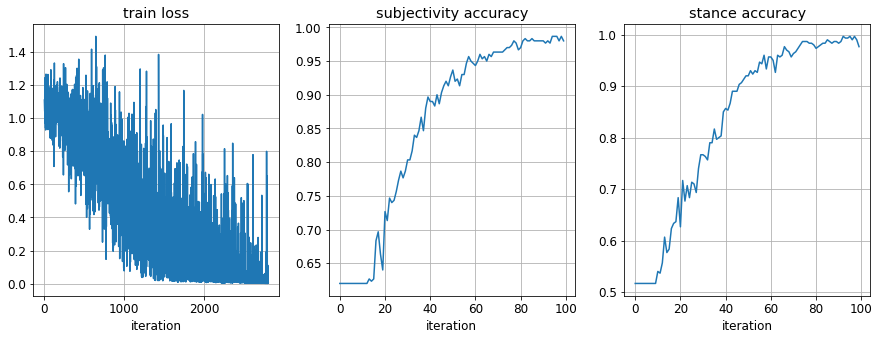

In [13]:
TPMO_TRAIN_LA_FIG = f'figures/two_phase_model_overfit_train_loss_accuracy_FIG'

if os.path.isfile(TPMO_TRAIN_LA_FIG):
    with open('figures/two_phase_model_overfit_train_loss_accuracy_FIG','rb') as fid:
        fig = pickle.load(fid)
else:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    ax[0].plot(losses); ax[0].set_title('train loss'); ax[0].set_xlabel('iteration'); ax[0].grid(True)
    ax[1].plot(sub_accuracies); ax[1].set_title('subjectivity accuracy'); ax[1].set_xlabel('iteration'); ax[1].grid(True)
    ax[2].plot(stance_accuracies); ax[2].set_title('stance accuracy'); ax[2].set_xlabel('iteration'); ax[2].grid(True)
    
    with open('figures/two_phase_model_overfit_train_loss_accuracy_FIG','wb') as fid:
        pickle.dump(fig, fid)

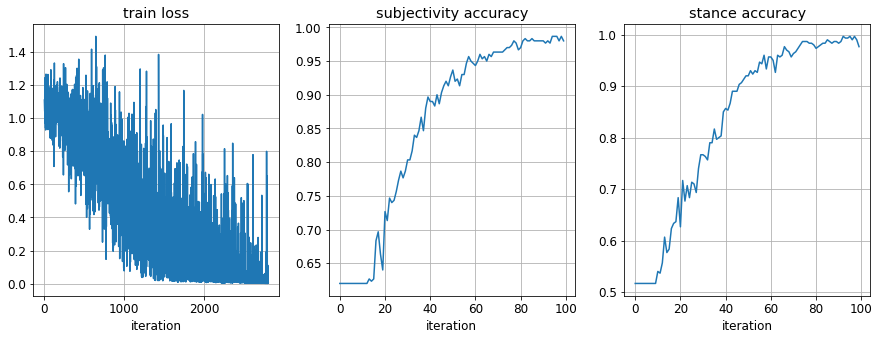

In [14]:
fig

# Testing

In order to test our model's generalization, effeciency and accuracy we need to evaluate the model on a new unseen set and that is our test set 

In [15]:
losses = []
sub_accuracies = []
stance_accuracies = []
for epoch in range(10):
    
    print(f'=== test EPOCH {epoch+1}/{10} ===')
    losses += train_two_phase_rnn(two_phase_model, dl_train, optimizer, sub_loss_fn, stance_loss_fn, BATCHES_PER_EPOCH)
    sub_acc, stance_acc = eval_two_phase_rnn(two_phase_model, dl_test)
    sub_accuracies += [sub_acc]
    stance_accuracies += [stance_acc]

=== test EPOCH 1/10 ===
train loss=0.00397846382111311,: 100%|█████████████████████████████████████████████████| 28/28 [00:04<00:00,  6.17it/s]
 sentiment accuracy=0.7023810148239136, stance accuracy=0.4087301194667816 : 100%|█████| 28/28 [00:00<00:00, 44.99it/s]
=== test EPOCH 2/10 ===
train loss=0.004511168226599693,: 100%|████████████████████████████████████████████████| 28/28 [00:03<00:00,  7.45it/s]
 sentiment accuracy=0.7460317611694336, stance accuracy=0.39801591634750366 : 100%|████| 28/28 [00:00<00:00, 42.60it/s]
=== test EPOCH 3/10 ===
train loss=0.4182850420475006,: 100%|██████████████████████████████████████████████████| 28/28 [00:03<00:00,  7.73it/s]
 sentiment accuracy=0.7353175282478333, stance accuracy=0.34285712242126465 : 100%|████| 28/28 [00:00<00:00, 42.60it/s]
=== test EPOCH 4/10 ===
train loss=0.024855712428689003,: 100%|████████████████████████████████████████████████| 28/28 [00:03<00:00,  7.90it/s]
 sentiment accuracy=0.7095237970352173, stance accuracy=0.390872

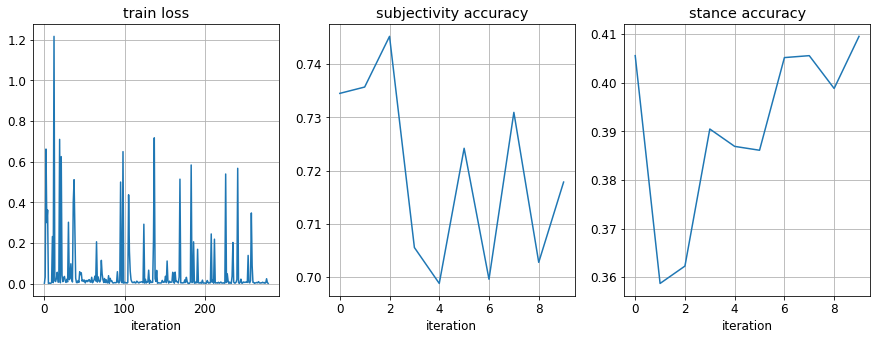

In [16]:
TPMO_TRAIN_LA_FIG = f'figures/two_phase_model_overfit_test_loss_accuracy_FIG'

if os.path.isfile(TPMO_TRAIN_LA_FIG):
    with open('figures/two_phase_model_overfit_test_loss_accuracy_FIG','rb') as fid:
        fig = pickle.load(fid)
else:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    ax[0].plot(losses); ax[0].set_title('train loss'); ax[0].set_xlabel('iteration'); ax[0].grid(True)
    ax[1].plot(sub_accuracies); ax[1].set_title('subjectivity accuracy'); ax[1].set_xlabel('iteration'); ax[1].grid(True)
    ax[2].plot(stance_accuracies); ax[2].set_title('stance accuracy'); ax[2].set_xlabel('iteration'); ax[2].grid(True)
    
    with open('figures/two_phase_model_overfit_test_loss_accuracy_FIG','wb') as fid:
        pickle.dump(fig, fid)

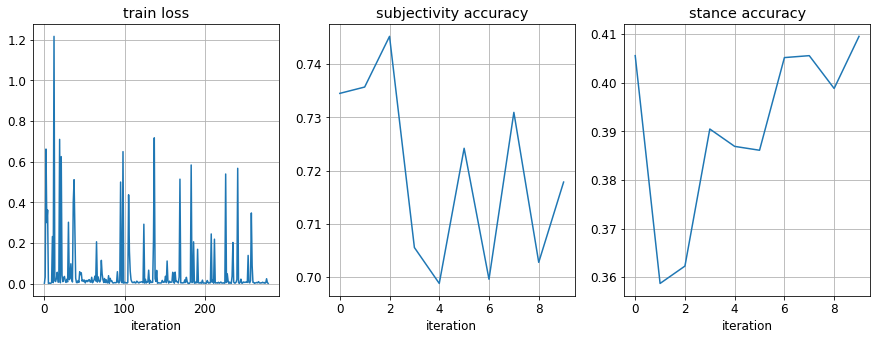

In [17]:
fig

# Experiments

in our experiments we intend to find the right parameters that would bring a stabilized training, prevent overfitting and result in high accuracies, in other words tuning our hyperparameters

### hyper parameters

1. dropout: which for some probability disconnects layers in the model preventing our model from overfitting
2. bach size: the number of batches we split our input into in order to train the model
3. epochs: the number of epoch our model trains
4. batches each epoch: number of max batches in each epoch 
5. learn rate: the rate in which we want the loss function to converge.
6. embedding dimension: the dimension we use for embedding the meaning of the words 
7. hidden dimensions: the hidden dimensions of the rnn layers we have in our models 
8. number of layers: the number of layers in our rnns


In [19]:
from implementations.training import train_two_phase_rnn
from implementations.training import eval_two_phase_rnn
import torch.nn as nn

EMB_DIM = [128,256]
HID_DIM = [64,128]
NUM_LAYERS = [1,2]
DROP_OUT = [0.1]
VOCAB_SIZE = len(TWEET.vocab)
EPOCHS = 100
BATCHES_PER_EPOCH=28
LR=[1e-3]
best_acc = 0.0

two_phase_model_experiment = TwoPhaseLSTM(VOCAB_SIZE, EMB_DIM[0], HID_DIM[0],NUM_LAYERS[0], DROP_OUT[0])
CHECKPOINTS_FILE_FINAL = f'checkpoints/two_phase_models_experiments_checkpoints.dat'

if os.path.isfile(CHECKPOINTS_FILE_FINAL):
    print(f'=== {CHECKPOINTS_FILE_FINAL} exists, skipping training...')    
    checkpoint_data = torch.load(CHECKPOINTS_FILE_FINAL)
    #     print(checkpoint_data)
    two_phase_model_experiment.load_state_dict(checkpoint_data)
    # checkpoint_data
else:         
    for e in EMB_DIM:
        for h in HID_DIM:
            for n in NUM_LAYERS:
                for d in DROP_OUT:
                    for l in LR:
                        two_phase_model_experiment = TwoPhaseLSTM(VOCAB_SIZE, e, h,n,d)
                        optimizer1 = torch.optim.Adam(two_phase_model_experiment.parameters(), lr=l)
                        sub_loss_fn = torch.nn.NLLLoss()
                        stance_loss_fn = torch.nn.NLLLoss()

                        losses = []
                        sub_accuracies = []
                        stance_accuracies = []
                        two_phase_model.zero_grad()
                        for epoch in range(EPOCHS):
                            print(f'=== EPOCH {epoch+1}/{EPOCHS} ===')
                            losses += train_two_phase_rnn(two_phase_model_experiment, dl_train, optimizer1, sub_loss_fn, stance_loss_fn, BATCHES_PER_EPOCH)
                            sub_acc, stance_acc = eval_two_phase_rnn(two_phase_model_experiment, dl_test)
                            sub_accuracies += [sub_acc]
                            stance_accuracies += [stance_acc]
                            if best_acc is not None and stance_acc > best_acc + 0.1:
                                best_acc = stance_acc
                                torch.save(two_phase_model_experiment.state_dict(), 'checkpoints/two_phase_models_experiments_checkpoints.dat')

=== checkpoints/two_phase_models_experiments_checkpoints.dat exists, skipping training...


C:\Users\User\anaconda3\envs\AI-project\lib\site-packages\torch\nn\modules\rnn.py:57: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


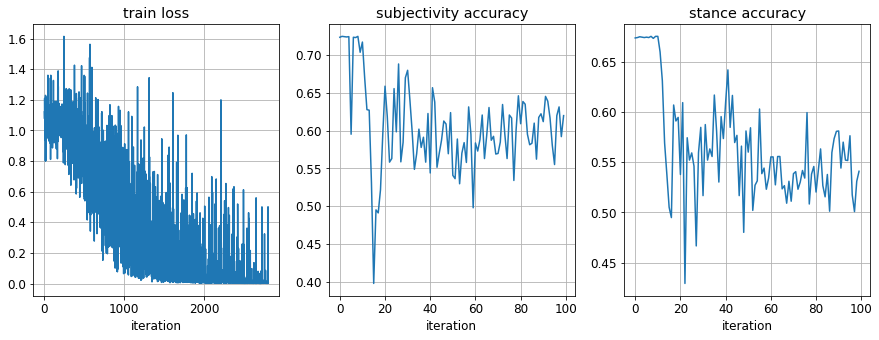

In [20]:
TPMO_TRAIN_LA_FIG = f'figures/two_phase_model_experience_loss_accuracy_FIG'

if os.path.isfile(TPMO_TRAIN_LA_FIG):
    with open('figures/two_phase_model_experience_loss_accuracy_FIG','rb') as fid:
        fig = pickle.load(fid)
else:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    ax[0].plot(losses); ax[0].set_title('train loss'); ax[0].set_xlabel('iteration'); ax[0].grid(True)
    ax[1].plot(sub_accuracies); ax[1].set_title('subjectivity accuracy'); ax[1].set_xlabel('iteration'); ax[1].grid(True)
    ax[2].plot(stance_accuracies); ax[2].set_title('stance accuracy'); ax[2].set_xlabel('iteration'); ax[2].grid(True)
    
    with open('figures/two_phase_model_experience_loss_accuracy_FIG','wb') as fid:
        pickle.dump(fig, fid)

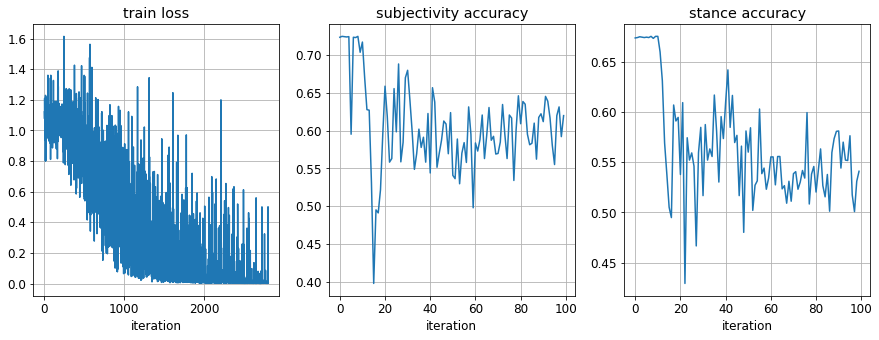

In [21]:
fig

## Pre-Trained Word Embeddings

The main idea behind it is to use public embeddings that are already trained on large datasets, so instead of initializing our neural network weights randomly, we will set these pre trained embeddings as initialization weights. This trick helps to accelerate training and boost the performance of our model. We will use the pre-trained word2vec from GloVe twitter data 

In [22]:
emb_dim = 200

In [23]:
words = []
idx = 0
word2idx = {}
vectors = []

with open(f'pretrained_embeddings/glove.twitter.27B.200d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
        
glove = {w: torch.FloatTensor(vectors[word2idx[w]]) for w in words}

In [24]:
matrix_len = len(TWEET.vocab)
print(len(TWEET.vocab))
weights_matrix = torch.zeros((matrix_len, emb_dim))
words_found = 0
print(weights_matrix.shape)

for i, word in enumerate(TWEET.vocab.itos):
#     print(word)
    if(i >= matrix_len):
        break
    try:
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = torch.rand((emb_dim, ))
words_found

12528
torch.Size([12528, 200])


5318

## Positional information 

The attention mechanism is completely invariant to sequence ordering, thus attention networks
need to incorporate positional information we focused on one positional technique:
#### Sinusoidal Position Encoding
Positional encoding (PE) vectors are created using sine and cosine functions of difference frequencies and then are added to the input embeddings.
we used the following sine and cosine functions:

$\newline \quad PE(pos,2i)= sin(pos\ /(10000^{2i\ / dmodel})) \newline$ $\quad PE(pos,2i+1)= sin(pos\ /(10000^{2i+1\ / dmodel})) \newline$
where pos is the sentence position and i is the dimension.

## The architecture with the positional encoder

##### the first phase:
1. Embedding
2. LSTM
3. Average
4. Linear

##### the second phase:
1. Embedding
2. Positional Encoder
3. Feed-forward: feed forward layer to acquire the representation of the keys and values
4. Attention with the queries as the last output from the LSTM in this phase, keys and values are from the first phase
5. LSTM
6. Average
7. Linear



In [25]:
from implementations.models import PeTwoPhaseLSTM
HID_DIM = 100
NUM_LAYERS = 2
DROP_OUT = 0.1

pe_two_phase_model = PeTwoPhaseLSTM(weights_matrix, HID_DIM,NUM_LAYERS,DROP_OUT)
y_stance, y_sub = pe_two_phase_model(X)
print('y_stance: (S, B, V_tgt) =', tuple(y_stance.shape))
print('y_sub: (S, B, V_tgt) =', tuple(y_sub.shape))
pe_two_phase_model

y_stance: (S, B, V_tgt) = (10, 3)
y_sub: (S, B, V_tgt) = (10, 3)


PeTwoPhaseLSTM(
  (sub): PeSubjectivityLSTM(
    (embedding): Embedding(12528, 200)
    (lstm): LSTM(200, 100, num_layers=2, dropout=0.1)
  )
  (stance): PeStanceLSTM(
    (embedding): Embedding(12528, 200)
    (ff): FeedForward(
      (dropout): Dropout(p=0.1, inplace=False)
      (linear_1): Linear(in_features=100, out_features=200, bias=True)
      (linear_2): Linear(in_features=200, out_features=100, bias=True)
    )
    (attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=100, out_features=100, bias=True)
    )
    (lstm): LSTM(400, 100, num_layers=2, dropout=0.1)
  )
  (pe): PositionalEncoder()
  (linear1): Linear(in_features=100, out_features=3, bias=True)
  (log_softmax): LogSoftmax(dim=1)
  (linear2): Linear(in_features=100, out_features=3, bias=True)
)

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(pe_two_phase_model):,} trainable weights.')

The model has 564,506 trainable weights.


In [27]:
from implementations.training import train_pe_two_phase_rnn
from implementations.training import eval_pe_two_phase_rnn
import torch.nn as nn

EPOCHS = 200
BATCHES_PER_EPOCH=28
LR=1e-3

CHECKPOINTS_FILE_FINAL = f'checkpoints/pe_two_phase_model_overfit_checkpoint_3.dat'

optimizer = torch.optim.Adam(pe_two_phase_model.parameters(), lr=LR)
sub_loss_fn = nn.NLLLoss()
stance_loss_fn = nn.NLLLoss()


if os.path.isfile(CHECKPOINTS_FILE_FINAL):
    print(f'=== {CHECKPOINTS_FILE_FINAL} exists, skipping training...')    
    checkpoint_data = torch.load(CHECKPOINTS_FILE_FINAL)
#     print(checkpoint_data)
    pe_two_phase_model.load_state_dict(checkpoint_data)
# checkpoint_data
else: 
    losses = []
    sub_accuracies = []
    stance_accuracies = []
    for epoch in range(EPOCHS):

        print(f'=== EPOCH {epoch+1}/{EPOCHS} ===')
        losses += train_pe_two_phase_rnn(pe_two_phase_model, dl_train, optimizer, sub_loss_fn, stance_loss_fn, BATCHES_PER_EPOCH)
        sub_acc, stance_acc = eval_pe_two_phase_rnn(pe_two_phase_model, dl_valid)
        sub_accuracies += [sub_acc]
        stance_accuracies += [stance_acc]
    torch.save(pe_two_phase_model.state_dict(), 'checkpoints/pe_two_phase_model_overfit_checkpoint_3.dat')

=== checkpoints/pe_two_phase_model_overfit_checkpoint_3.dat exists, skipping training...


## Testing

Same as before

In [28]:
sub_accuracies = []
stance_accuracies = []
for epoch in range(10):
    
    print(f'=== test EPOCH {epoch+1}/{EPOCHS} ===')
    sub_acc, stance_acc = eval_pe_two_phase_rnn(pe_two_phase_model, dl_test)
    sub_accuracies += [sub_acc]
    stance_accuracies += [stance_acc]

=== test EPOCH 1/200 ===
 sentiment accuracy=0.759920597076416, stance accuracy=0.5952381491661072 : 100%|██████| 28/28 [00:02<00:00, 11.78it/s]
=== test EPOCH 2/200 ===
 sentiment accuracy=0.7527777552604675, stance accuracy=0.5944444537162781 : 100%|█████| 28/28 [00:02<00:00, 11.45it/s]
=== test EPOCH 3/200 ===
 sentiment accuracy=0.7420635223388672, stance accuracy=0.5876984000205994 : 100%|█████| 28/28 [00:02<00:00, 11.63it/s]
=== test EPOCH 4/200 ===
 sentiment accuracy=0.7567459940910339, stance accuracy=0.5916667580604553 : 100%|█████| 28/28 [00:02<00:00, 11.80it/s]
=== test EPOCH 5/200 ===
 sentiment accuracy=0.7424603700637817, stance accuracy=0.5920635461807251 : 100%|█████| 28/28 [00:02<00:00, 11.61it/s]
=== test EPOCH 6/200 ===
 sentiment accuracy=0.7496030926704407, stance accuracy=0.6019842028617859 : 100%|█████| 28/28 [00:02<00:00, 11.81it/s]
=== test EPOCH 7/200 ===
 sentiment accuracy=0.7567458748817444, stance accuracy=0.595634937286377 : 100%|██████| 28/28 [00:02<00:

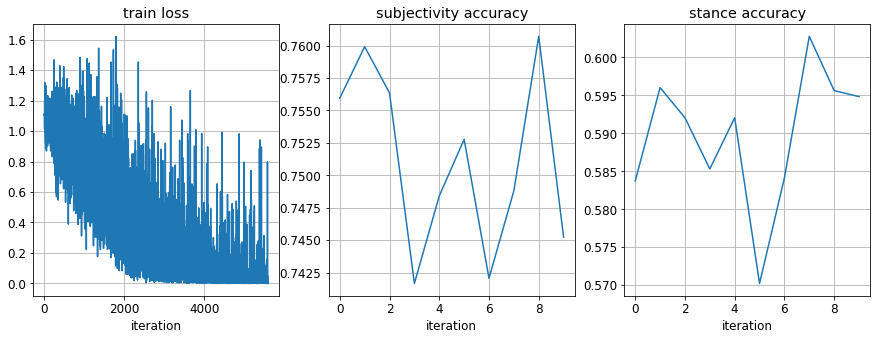

In [29]:
TPMO_TRAIN_LA_FIG = f'figures/pe_two_phase_model_overfit_test_loss_accuracy_FIG'

if os.path.isfile(TPMO_TRAIN_LA_FIG):
    with open('figures/pe_two_phase_model_overfit_test_loss_accuracy_FIG','rb') as fid:
        fig = pickle.load(fid)
else:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    ax[0].plot(losses); ax[0].set_title('train loss'); ax[0].set_xlabel('iteration'); ax[0].grid(True)
    ax[1].plot(sub_accuracies); ax[1].set_title('subjectivity accuracy'); ax[1].set_xlabel('iteration'); ax[1].grid(True)
    ax[2].plot(stance_accuracies); ax[2].set_title('stance accuracy'); ax[2].set_xlabel('iteration'); ax[2].grid(True)
    
    with open('figures/pe_two_phase_model_overfit_test_loss_accuracy_FIG','wb') as fid:
        pickle.dump(fig, fid)

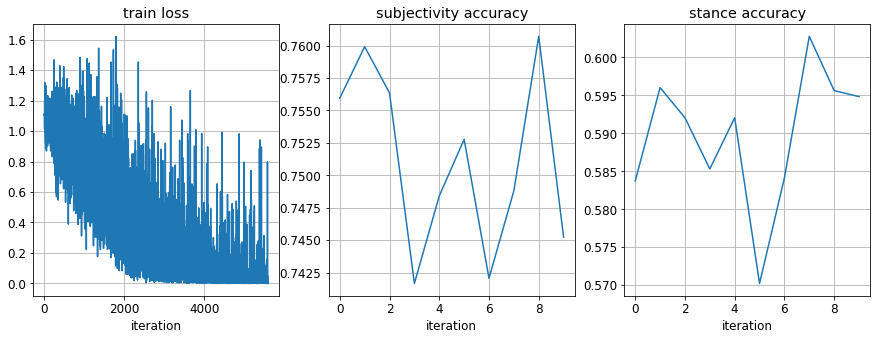

In [30]:
fig

## Base Line models 

here we evaluate previous state-of-the-art technique models in order to have a comparitive analysis:
1. GRU
2. LSTMs

In [31]:
from implementations.models import BaseLineLSTM

EMB_DIM = 128
HID_DIM = 64
NUM_LAYERS = 2
DROP_OUT = 0.1
VOCAB_SIZE = len(TWEET.vocab)

baseline_lstm_model = BaseLineLSTM(VOCAB_SIZE, EMB_DIM, HID_DIM,NUM_LAYERS,DROP_OUT)
y_stance = baseline_lstm_model(X)
print('y_stance: (S, B, V_tgt) =', tuple(y_stance.shape))

y_stance: (S, B, V_tgt) = (10, 3)


## Training 

Same as before

In [39]:
from implementations.training import train_baseline_rnn
from implementations.training import eval_baseline_rnn
import torch.nn as nn

EPOCHS = 100
BATCHES_PER_EPOCH=28
LR=1e-3

CHECKPOINTS_FILE_FINAL = f'checkpoints/baseline_lstm_model_overfit_checkpoint.dat'

optimizer = torch.optim.Adam(baseline_lstm_model.parameters(), lr=LR)
stance_loss_fn = nn.NLLLoss()

if os.path.isfile(CHECKPOINTS_FILE_FINAL):
    print(f'=== {CHECKPOINTS_FILE_FINAL} exists, skipping training...')    
    checkpoint_data = torch.load(CHECKPOINTS_FILE_FINAL)
#     print(checkpoint_data)
    baseline_lstm_model.load_state_dict(checkpoint_data)
# checkpoint_data

else:
    losses = []
    sub_accuracies = []
    stance_accuracies = []
    for epoch in range(EPOCHS):

        print(f'=== EPOCH {epoch+1}/{EPOCHS} ===')
        losses += train_baseline_rnn(baseline_lstm_model, dl_train, optimizer, stance_loss_fn, BATCHES_PER_EPOCH)
        stance_acc= eval_baseline_rnn(baseline_lstm_model, dl_valid)
        stance_accuracies += [stance_acc]
    torch.save(baseline_lstm_model.state_dict(), 'checkpoints/baseline_lstm_model_overfit_checkpoint.dat')

=== EPOCH 1/100 ===
 stance accuracy=0.5166666507720947 : 100%|████████████████████████████████████████████| 30/30 [00:00<00:00, 69.63it/s]
=== EPOCH 2/100 ===
 stance accuracy=0.5166666507720947 : 100%|████████████████████████████████████████████| 30/30 [00:00<00:00, 77.73it/s]
=== EPOCH 3/100 ===
 stance accuracy=0.51666659116745 : 100%|██████████████████████████████████████████████| 30/30 [00:00<00:00, 79.16it/s]
=== EPOCH 4/100 ===
 stance accuracy=0.5233333110809326 : 100%|████████████████████████████████████████████| 30/30 [00:00<00:00, 74.64it/s]
=== EPOCH 5/100 ===
 stance accuracy=0.5399999618530273 : 100%|████████████████████████████████████████████| 30/30 [00:00<00:00, 73.19it/s]
=== EPOCH 6/100 ===
 stance accuracy=0.54666668176651 : 100%|██████████████████████████████████████████████| 30/30 [00:00<00:00, 76.35it/s]
=== EPOCH 7/100 ===
 stance accuracy=0.5600000619888306 : 100%|████████████████████████████████████████████| 30/30 [00:00<00:00, 66.70it/s]
=== EPOCH 8/100 ===


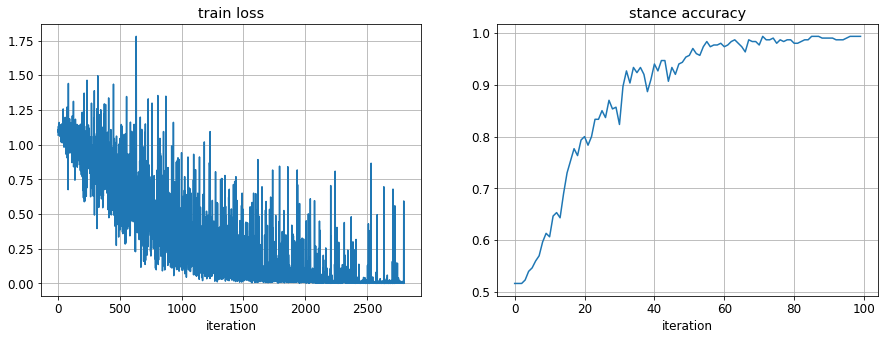

In [40]:
TPMO_TRAIN_LA_FIG = f'figures/baseline_lstm_overfit_train_loss_accuracy_FIG'

if os.path.isfile(TPMO_TRAIN_LA_FIG):
    with open('figures/baseline_lstm_overfit_train_loss_accuracy_FIG','rb') as fid:
        fig = pickle.load(fid)
else:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ax[0].plot(losses); ax[0].set_title('train loss'); ax[0].set_xlabel('iteration'); ax[0].grid(True)
    ax[1].plot(stance_accuracies); ax[1].set_title('stance accuracy'); ax[1].set_xlabel('iteration'); ax[1].grid(True)
    
    with open('figures/baseline_lstm_overfit_train_loss_accuracy_FIG','wb') as fid:
        pickle.dump(fig, fid)

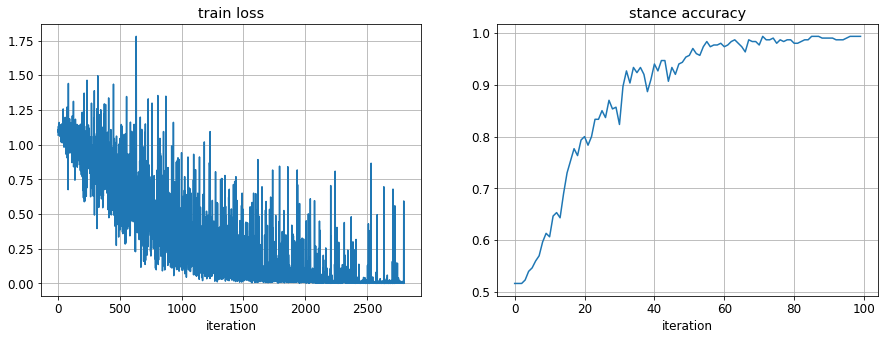

In [41]:
fig

## Testing the baseline model 

In [47]:
stance_accuracies = []
for epoch in range(10):
    
    print(f'=== test EPOCH {epoch+1}/{10} ===')
    stance_acc = eval_baseline_rnn(baseline_lstm_model, dl_test)
    stance_accuracies += [stance_acc]

=== test EPOCH 1/10 ===
 stance accuracy=0.4353175163269043 : 100%|████████████████████████████████████████████| 28/28 [00:00<00:00, 78.86it/s]
=== test EPOCH 2/10 ===
 stance accuracy=0.44087299704551697 : 100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 92.05it/s]
=== test EPOCH 3/10 ===
 stance accuracy=0.4226190745830536 : 100%|████████████████████████████████████████████| 28/28 [00:00<00:00, 94.21it/s]
=== test EPOCH 4/10 ===
 stance accuracy=0.42658731341362 : 100%|██████████████████████████████████████████████| 28/28 [00:00<00:00, 94.21it/s]
=== test EPOCH 5/10 ===
 stance accuracy=0.44087299704551697 : 100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 80.44it/s]
=== test EPOCH 6/10 ===
 stance accuracy=0.44484132528305054 : 100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 78.86it/s]
=== test EPOCH 7/10 ===
 stance accuracy=0.4404761791229248 : 100%|████████████████████████████████████████████| 28/28 [00:00<00:00, 66.

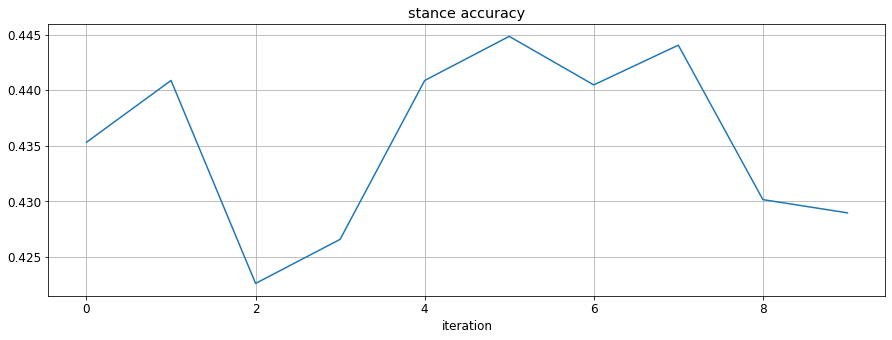

In [48]:
TPMO_TRAIN_LA_FIG = f'figures/baseline_lstm_overfit_test_loss_accuracy_FIG'

if os.path.isfile(TPMO_TRAIN_LA_FIG):
    with open('figures/baseline_lstm_overfit_test_loss_accuracy_FIG','rb') as fid:
        fig = pickle.load(fid)
else:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    ax.plot(stance_accuracies); ax.set_title('stance accuracy'); ax.set_xlabel('iteration'); ax.grid(True)
    
    with open('figures/baseline_lstm_overfit_test_loss_accuracy_FIG','wb') as fid:
        pickle.dump(fig, fid)

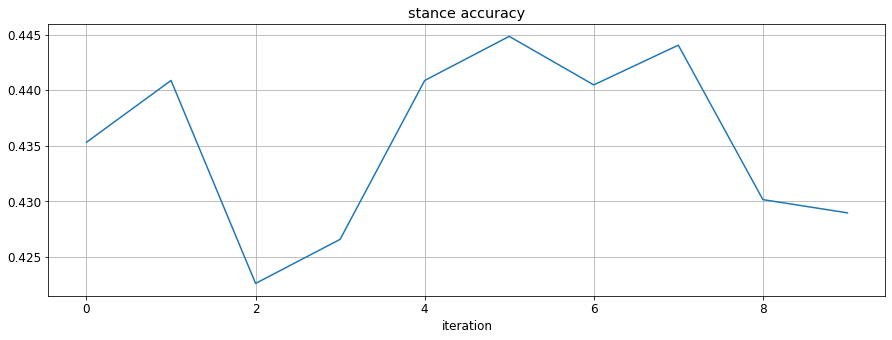

In [49]:
fig